In [40]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [41]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc
from datetime import timedelta, datetime


In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [17]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [18]:
# View all of the classes that automap found
classes = Base.classes.keys()
print(classes)

['measurement', 'station']


In [19]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [23]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


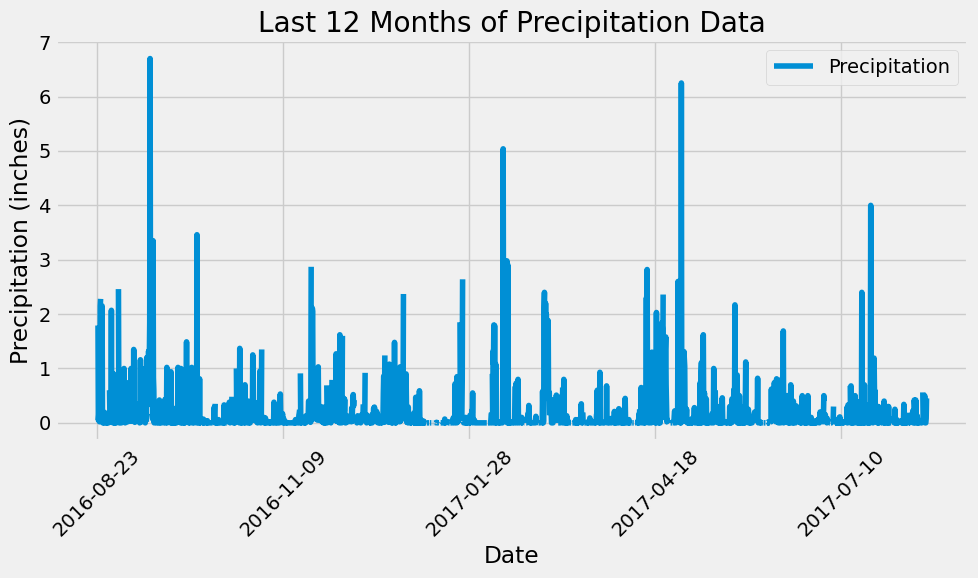

In [25]:
# Calculate the date one year from the last date
one_year_ago = (pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)).date()

# Query to retrieve the last 12 months of precipitation data
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame with column names
precipitation_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')

# Plot the data using Pandas Plotting with Matplotlib
precipitation_df.plot(x='Date', y='Precipitation', figsize=(10, 6))
plt.title('Last 12 Months of Precipitation Data')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [26]:
# Use Pandas to calculate the summary statistics for the precipitation data
print(precipitation_df.describe())

       Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Measurement.station.distinct())).scalar()

print("Total number of stations:", total_stations)

Total number of stations: 9


In [33]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()

print("Most Active Stations:")
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Most Active Stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [34]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations[0][0] 
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

lowest_temp, highest_temp, avg_temp = temperature_stats[0]

print(f"Temperature Statistics for Station {most_active_station}:")
print(f"Lowest Temperature: {lowest_temp} °F")
print(f"Highest Temperature: {highest_temp} °F")
print(f"Average Temperature: {avg_temp:.2f} °F")

Temperature Statistics for Station USC00519281:
Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66 °F


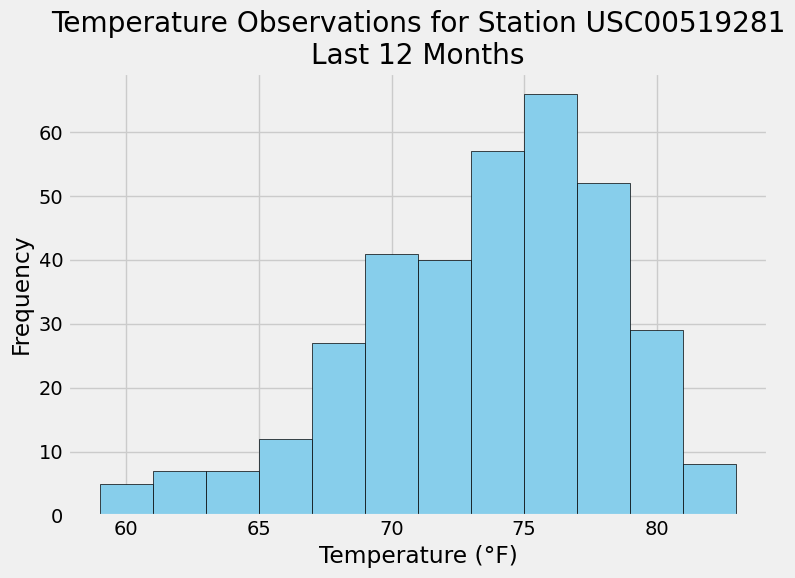

In [42]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Convert most_recent_date to a datetime object
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year ago from the most recent date
one_year_ago = most_recent_date - timedelta(days=365)

# Query to retrieve the temperature observations for the most active station in the last 12 months
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station,
           Measurement.date >= one_year_ago,
           Measurement.date <= most_recent_date).all()

# Extract the temperature data into a list
temperatures = [temp[0] for temp in temperature_data]

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, color='skyblue', edgecolor='black')
plt.title(f"Temperature Observations for Station {most_active_station}\nLast 12 Months")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.tight_layout()

# Show the plot
plt.show()

# Close Session

In [43]:
# Close Session
session.close()